In [372]:
# import os
# os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"

# import jax
import jax
jax.config.update('jax_platform_name', 'cpu')
# print("jax version:", jax.__version__)
# print("jax devices:", jax.devices())
import jax.numpy as jnp
import numpy as np
import functools
import abc
import torch
import torch.nn as nn
from cvxopt import matrix, solvers
import cvxpy as cp

from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import pypalettes

import hj_reachability as hj
from hj_reachability.finite_differences import upwind_first

from hjnnv import hjnnvUncertaintyAwareFilter
from dynamic_models.beacon import BeaconDynamics
from simulators.beacon_env.desired_trajectories import DesiredTrajectory


# jax.config.update("jax_cudnn_use_autotuned", False)
import warnings
warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
import jax.numpy as jnp
import jax
import numpy as np

import hj_reachability as hj
import torch

from dynamic_models.dynamics import HJNNVDynamics
from learned_models.beacon.estimators import MLP, CNN

from utils.mlp2jax import torch_mlp2jax
from utils.torch2jaxmodel import torch_to_jax_model


class CBF_Comparison(HJNNVDynamics):
    def __init__(self,
                 dt=0.1,
                 max_input=1.0,
                 max_disturbance=0.01,
                 obs_disturbance=0.02,
                 control_mode="max",
                 disturbance_mode="min",
                 control_space=None,
                 disturbance_space=None,
                 model_name=None,
                 random_seed=0
                 ):

        if control_space is None:
            control_space = hj.sets.Box(jnp.array([-max_input,]),
                                        jnp.array([max_input,]))
        if disturbance_space is None:
            disturbance_space = hj.sets.Box(jnp.array([-max_disturbance]),
                                            jnp.array([max_disturbance,]))

        if model_name is not None:
            self.load_estimator(model_name=model_name)

        super().__init__(
            dt,
            control_mode,
            disturbance_mode,
            control_space,
            disturbance_space,
            random_seed
        )

    def open_loop_dynamics(self, state, time):
        xdot = state * (state - 1.05) * (state + 1.05)
        return xdot

    def control_jacobian(self, state, time):
        return jnp.array(
            [(1 - state * state)]
        )

    def disturbance_jacobian(self, state, time):
        return jnp.eye(1)

    def get_observation(self, state, time):
        return state


In [3]:
def cbf_controller(state):
    return jnp.array([0.0])

cbf_dynamics = CBF_Comparison(
    dt=0.01,
    max_input=100.0,
    max_disturbance=0.001,
    obs_disturbance=0.001,
    model_name=None
)

def simulate_trajectory(dynamics, initial_state, control_policy, num_steps, use_observations=False):
    state = initial_state
    trajectory = [(state, dynamics.get_observation(state, time=0))]
    for t in range(num_steps):
        if use_observations:
            obs = dynamics.get_observation(state, time=t)
            state_hat = dynamics.get_state_estimate(obs)
        else:
            state_hat = state
        control = control_policy(state_hat)
        disturbance = dynamics.get_random_disturbance()
        state = dynamics.step(state, control, disturbance, time=t+1)
        observation = dynamics.get_observation(state, time=t+1)
        trajectory.append((state, observation))
    return trajectory


In [4]:
initial_state = jnp.array([1.3])
trajectory = simulate_trajectory(
    dynamics=cbf_dynamics,
    initial_state=initial_state,
    control_policy=cbf_controller,
    num_steps=5000,
)


(0.0, 10.0)

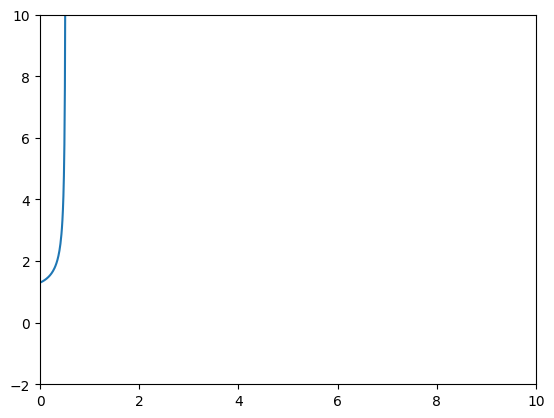

In [5]:
observations = jnp.array([obs for state, obs in trajectory])
states = jnp.array([state for state, obs in trajectory])
t = jnp.arange(len(states)) * cbf_dynamics.dt
plt.plot(t, states)
plt.ylim(-2, 10)
plt.xlim(0, 10)

In [265]:
epsilon = 0.01
dt = 0.01
max_input = 8.0
max_disturbance = 0.0000001
obs_disturbance = 0.0000001
seed = 0
dynamics = CBF_Comparison(
    dt=dt,
    max_input=max_input,
    max_disturbance=max_disturbance,
    obs_disturbance=obs_disturbance,
    model_name=None
)

grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
            hj.sets.Box(
                np.array([-6.]),
                np.array([6.])),
            (50,),
        )
values = -jnp.power(grid.states[..., 0], 2) + 1.0

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
cmap = 'viridis'

def estimation_function(observation):
    return observation

hjnnv_filter = hjnnvUncertaintyAwareFilter(
    dynamics=dynamics,
    pred_model=estimation_function,
    grid=grid,
    initial_values=values,
    num_controls=50,
    num_disturbances=3,
    time_horizon=10.0
)

100%|##########| 10.0000/10.0 [00:04<00:00,  2.49sim_s/s]


In [7]:
# grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
#             hj.sets.Box(
#                 np.array([-3.0]),
#                 np.array([3.0])),
#             (1000,),
#         )
# values = -jnp.power(grid.states[..., 0], 2) + 1.0

# solver_settings = hj.SolverSettings.with_accuracy("very_high",
#                                                   hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)

times = np.linspace(0, -10.0, 20)
initial_values = values
all_values = hj.solve(solver_settings, dynamics, grid, times, initial_values)

100%|##########| 10.0000/10.0 [00:05<00:00,  1.98sim_s/s]


In [8]:

vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), round(vmax) - round(vmin) + 1)
fig = plt.figure(figsize=(13, 8))


def render_frame(i, colorbar=False):
    plt.plot(grid.coordinate_vectors[0], all_values[i, :], color='blue')
    plt.plot(grid.coordinate_vectors[0], all_values[0, :], color='gray', linestyle='--')
    plt.plot(jnp.array([max_input, max_input]), jnp.array([-8.0, 1.5]), linestyle='--', color='red')
    plt.gca().grid(True)
    plt.ylim(-8, 1.5)



render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=500).to_html5_video())
plt.close(); animation


In [266]:
filter_type = "hjnnv_bestu"  # "none", "hj", "hjnnv_maxval", "hjnnv_bestu"
eps_multiplier = -1.0

state_history_hjnnv = []
state_hat_history_hjnnv = []
state_bounds_history_hjnnv = []

key = jax.random.PRNGKey(seed)
num_steps = 1000
dynamics.set_random_seed(seed)

state = jnp.array([1.3])
state_hat = state + epsilon * eps_multiplier
u = cbf_controller(state)
zero_counter = 0

for step in range(num_steps):
    key, subkey = jax.random.split(key)
    t = step * dynamics.dt
    # Simulate the system dynamics
    obs = dynamics.get_observation(state, time=step)
    u_nominal = cbf_controller(state)
    state_hat = state + epsilon * eps_multiplier
    
    time_start = time.time()
    if filter_type == "hjnnv_maxval" or filter_type == "hjnnv_bestu":
        state_bounds = hj.sets.Box(state_hat - epsilon, state_hat + epsilon)

        if filter_type == "hjnnv_maxval":
            v_star, u_star, worst_val, val_filter, min_vals, distances = hjnnv_filter.ua_filter_max_val(
                u_nominal,
                state_bounds,
                num_states=3,
                eps=1e-6
            )
        elif filter_type == "hjnnv_bestu":
            v_star, u_star, worst_val, val_filter, min_vals, distances, _, _, = hjnnv_filter.ua_filter_best_u(
                u_nominal,
                state_bounds,
                num_states=10,
                delta=0.01,
            )
    elif filter_type == "hj":

        lo = state - 1e-8
        hi = state + 1e-8
        state_bounds = hj.sets.Box(
            lo,
            hi
        )
        time_start = time.time()
        v_star, u_star, worst_val, val_filter, min_vals, distances = hjnnv_filter.ua_filter_max_val(
            u_nominal,
            state_bounds,
            num_states=2
        )
    elif filter_type == "none":
        u = u_nominal
        v_star = 0.0
        val_filter = 1.0  # positive value means no filtering
        lo = state - 1e-8
        hi = state + 1e-8
        state_bounds = hj.sets.Box(
            lo,
            hi
        )
    # if np.linalg.norm(state-1.0) < 1e-2:
    #     print(f"Step {step}: State near equilibrium, applying nominal control.")
    #     zero_counter += 1
    #     u = u_nominal
    # elif zero_counter < 100 and zero_counter > 0:
    #     print(f"Step {step}: In zero counter phase ({zero_counter}/100), applying nominal control.")
    #     zero_counter += 1
    #     u = u_nominal
    #     if zero_counter == 100:
    #         zero_counter = 0
    # else:
    print(f"Step {step}: {np.linalg.norm(state-1.0)}")
    if val_filter < 0.0:
        print(f"Step {step}: Using filtered control u_star={u_star}, state={state}, v_star={v_star}, val_filter={val_filter}")
        u = u_star
    else:
        u = u_nominal
    
    time_end = time.time()
    print(f"Step {step}: Filter execution time: {time_end - time_start:.5f} seconds")

    state_history_hjnnv.append(state)
    state_hat_history_hjnnv.append(state_hat)
    state_bounds_history_hjnnv.append(state_bounds)

    state = dynamics.step(state, u, dynamics.get_random_disturbance(), time=step)

Step 0: 0.2999999523162842
Step 0: Using filtered control u_star=[8.], state=[1.3], v_star=-0.5828132033348083, val_filter=-0.71799635887146
Step 0: Filter execution time: 0.17193 seconds
Step 1: 0.2524374723434448
Step 1: Using filtered control u_star=[8.], state=[1.2524375], v_star=-0.48571041226387024, val_filter=-0.5971089005470276
Step 1: Filter execution time: 0.00041 seconds
Step 2: 0.21278715133666992
Step 2: Using filtered control u_star=[8.], state=[1.2127872], v_star=-0.40440306067466736, val_filter=-0.4966509938240051
Step 2: Filter execution time: 0.00047 seconds
Step 3: 0.1795862913131714
Step 3: Using filtered control u_star=[8.], state=[1.1795863], v_star=-0.3360610604286194, val_filter=-0.4127480685710907
Step 3: Filter execution time: 0.00053 seconds
Step 4: 0.15168046951293945
Step 4: Using filtered control u_star=[8.], state=[1.1516805], v_star=-0.2784331142902374, val_filter=-0.34237557649612427
Step 4: Filter execution time: 0.00061 seconds
Step 5: 0.1281492710113

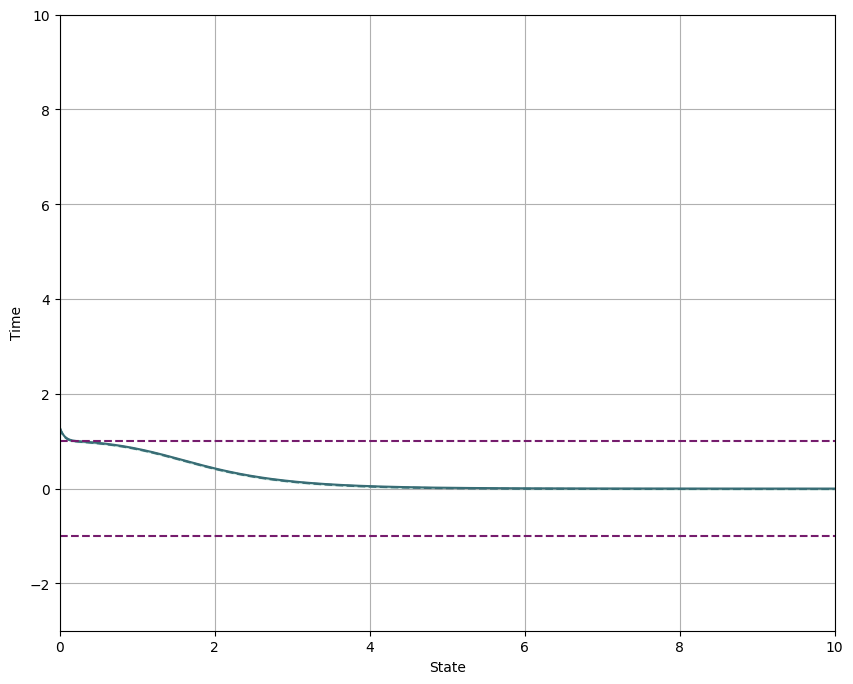

In [267]:
import matplotlib.patches as patches

rgb_colors = np.array(pypalettes.load_cmap("Alexandrite").rgb)/255.0
rgb_colors[2] = rgb_colors[2] * 0.8
black = list(rgb_colors[0])
pink = list(rgb_colors[1])
dark_teal = list(rgb_colors[2])
light_teal = list(rgb_colors[3])
purple = list(rgb_colors[4])
orange = list(rgb_colors[5])
light_purple = list(rgb_colors[6])
teal = list(rgb_colors[7])

# state_history_hjnnv = jnp.stack(state_history_hjnnv)

t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)



plt.figure(figsize=(10, 8))
plt.plot(t_samples, state_history_hjnnv, label="True State Trajectory", c=dark_teal)
plt.plot(t_samples, state_hat_history_hjnnv, label="Estimated State Trajectory", c=dark_teal, linestyle='--')
plt.plot(jnp.array([0, 10]), jnp.array([1, 1]), label="Safe Boundary", c=purple, linestyle='--', alpha=1.0)
plt.plot(jnp.array([0, 10]), jnp.array([-1, -1]), label="Safe Boundary", c=purple, linestyle='--', alpha=1.0)

highs = jnp.array([bounds.hi for bounds in state_bounds_history_hjnnv])
lows = jnp.array([bounds.lo for bounds in state_bounds_history_hjnnv])
plt.fill_between(t_samples, lows[:, 0], highs[:, 0], color=teal, alpha=0.2, label="State Bounds")


# plt.gca().add_patch(patches.Rectangle((0, 0), 10, 10, linestyle='-.', linewidth=1.5, edgecolor=light_purple, facecolor='none', label="Safe Boundary"))

# for i in range(len(state_bounds_history)):
#     bounds = state_bounds_history[i]
#     lo = bounds.lo
#     hi = bounds.hi
#     if i == len(state_bounds_history) - 1:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1,
#             edgecolor=teal + [0.75],
#             facecolor=teal + [0.25],
#             label="State Bounds",
#             zorder=0
#         )
#     else:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1.1,
#             edgecolor=teal + [0.4],
#             facecolor=teal + [0.02],
#             zorder=0
#         )
#     plt.gca().add_patch(rect)
plt.xlabel("State")
plt.ylabel("Time")
# plt.title("Trajectory: {} Filtering with Noisy Estimates".format(filter_type))
# plt.legend(loc="lower right", bbox_to_anchor=(1.18, 0.0), framealpha=1.0)
plt.xlim(0, 10)
plt.ylim(-3, 10)
plt.grid(True)
plt.show()

In [16]:
import cvxopt
import numpy as np
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

# minimize (1/2) x^T P x + q^T x
# subject to Gx <= h

state = 1.3

Lfh = -2 * np.power(state, 2) * (state - 1.05) * (state + 1.05)
Lgh = -2 * state * (1 - np.power(state, 2))
alphah = 1 - np.power(state, 2)
rho = 0.2 * Lgh * (Lgh + 1)

P = matrix([[2.0]])
q = matrix([0.0])
print(Lgh)
G = matrix([[-Lgh]])
h = matrix([Lfh + alphah - rho])

sol = solvers.qp(P, q, G, h)
print(sol['x'][0])


1.7940000000000005
2.0502994309796456


In [268]:
filter_type = "r-cbf"  # "none", "hj", "hjnnv_maxval", "hjnnv_bestu"
dt = 0.01
dynamics = CBF_Comparison(
    dt=dt,
    max_input=max_input,
    max_disturbance=max_disturbance,
    obs_disturbance=obs_disturbance,
    model_name=None
)

state_history_cbf = []
state_hat_history_cbf = []
state_bounds_history_cbf = []

key = jax.random.PRNGKey(seed)
num_steps = 1000
dynamics.set_random_seed(seed)

state = np.array([1.3])
state_hat = state.copy() + epsilon * eps_multiplier
u = cbf_controller(state)

for step in range(num_steps):
    key, subkey = jax.random.split(key)
    t = step * dynamics.dt
    # Simulate the system dynamics
    obs = dynamics.get_observation(state, time=step)
    u_nominal = cbf_controller(state)
    state_bounds = hj.sets.Box(state_hat - epsilon, state_hat + epsilon)

    time_start = time.time()

    # if step > 500:
    #     delta = -0.4
    state_hat = state + epsilon * eps_multiplier
    state_hat_ = state_hat[0]
    print(state_hat_)
    Lfh = -2 * np.power(state_hat_, 2) * (state_hat_ - 1.05) * (state_hat_ + 1.05)
    Lgh = -2 * state_hat_ * (1 - np.power(state_hat_, 2))
    alphah = 1 - np.power(state_hat_, 2)
    rho = 0.2 * Lgh * (Lgh + 1)

    print(Lgh)
    P = matrix([[2.0]])
    q = matrix([0.0])
    G = matrix([[-float(Lgh)]])
    h = matrix([float(Lfh + alphah - rho)])

    sol = solvers.qp(P, q, G, h)
    u = np.array([sol['x'][0]])

    
    time_end = time.time()
    print(f"Step {step}: Filter execution time: {time_end - time_start:.5f} seconds")

    state_history_cbf.append(state)
    state_hat_history_cbf.append(state_hat)
    state_bounds_history_cbf.append(state_bounds)

    state = dynamics.step(state, u, dynamics.get_random_disturbance(), time=step)

1.29
1.7133780000000003
Step 0: Filter execution time: 0.00095 seconds
1.2836914
1.663314
Step 1: Filter execution time: 0.00108 seconds
1.2775888
1.6154684
Step 2: Filter execution time: 0.00118 seconds
1.2716814
1.5696965
Step 3: Filter execution time: 0.00108 seconds
1.2659593
1.5258679
Step 4: Filter execution time: 0.00147 seconds
1.260413
1.4838617
Step 5: Filter execution time: 0.00122 seconds
1.2550343
1.4435685
Step 6: Filter execution time: 0.00109 seconds
1.2498151
1.4048867
Step 7: Filter execution time: 0.00108 seconds
1.2447479
1.3677223
Step 8: Filter execution time: 0.00133 seconds
1.2398258
1.3319899
Step 9: Filter execution time: 0.00152 seconds
1.2350426
1.2976102
Step 10: Filter execution time: 0.00143 seconds
1.230392
1.2645093
Step 11: Filter execution time: 0.00101 seconds
1.2258683
1.2326185
Step 12: Filter execution time: 0.00103 seconds
1.2214665
1.2018754
Step 13: Filter execution time: 0.00101 seconds
1.2171814
1.1722203
Step 14: Filter execution time: 0.000

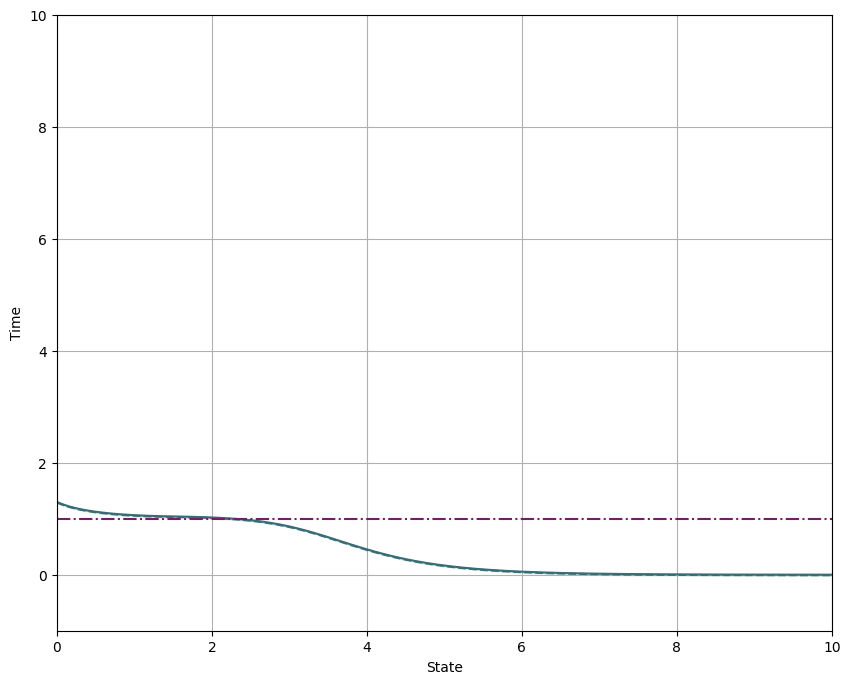

In [269]:
import matplotlib.patches as patches

rgb_colors = np.array(pypalettes.load_cmap("Alexandrite").rgb)/255.0
rgb_colors[2] = rgb_colors[2] * 0.8
black = list(rgb_colors[0])
pink = list(rgb_colors[1])
dark_teal = list(rgb_colors[2])
light_teal = list(rgb_colors[3])
purple = list(rgb_colors[4])
orange = list(rgb_colors[5])
light_purple = list(rgb_colors[6])
teal = list(rgb_colors[7])

# state_history = jnp.stack(state_history)

t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)



plt.figure(figsize=(10, 8))
plt.plot(t_samples, state_history_cbf, label="True State Trajectory", c=dark_teal)
plt.plot(t_samples, state_hat_history_cbf, label="Estimated State Trajectory", c=dark_teal, linestyle='--')
plt.plot(jnp.array([0, 10]), jnp.array([1, 1]), label="Safe Boundary", c=purple, linestyle='-.', alpha=1.0)

highs = jnp.array([bounds.hi for bounds in state_bounds_history_cbf])
lows = jnp.array([bounds.lo for bounds in state_bounds_history_cbf])
plt.fill_between(t_samples, lows[:, 0], highs[:, 0], color=teal, alpha=0.2, label="State Bounds")


# plt.gca().add_patch(patches.Rectangle((0, 0), 10, 10, linestyle='-.', linewidth=1.5, edgecolor=light_purple, facecolor='none', label="Safe Boundary"))

# for i in range(len(state_bounds_history)):
#     bounds = state_bounds_history[i]
#     lo = bounds.lo
#     hi = bounds.hi
#     if i == len(state_bounds_history) - 1:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1,
#             edgecolor=teal + [0.75],
#             facecolor=teal + [0.25],
#             label="State Bounds",
#             zorder=0
#         )
#     else:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1.1,
#             edgecolor=teal + [0.4],
#             facecolor=teal + [0.02],
#             zorder=0
#         )
#     plt.gca().add_patch(rect)
plt.xlabel("State")
plt.ylabel("Time")
# plt.title("Trajectory: {} Filtering with Noisy Estimates".format(filter_type))
# plt.legend(loc="lower right", bbox_to_anchor=(1.18, 0.0), framealpha=1.0)
plt.xlim(0, 10)
plt.ylim(-1, 10)
plt.grid(True)
plt.show()

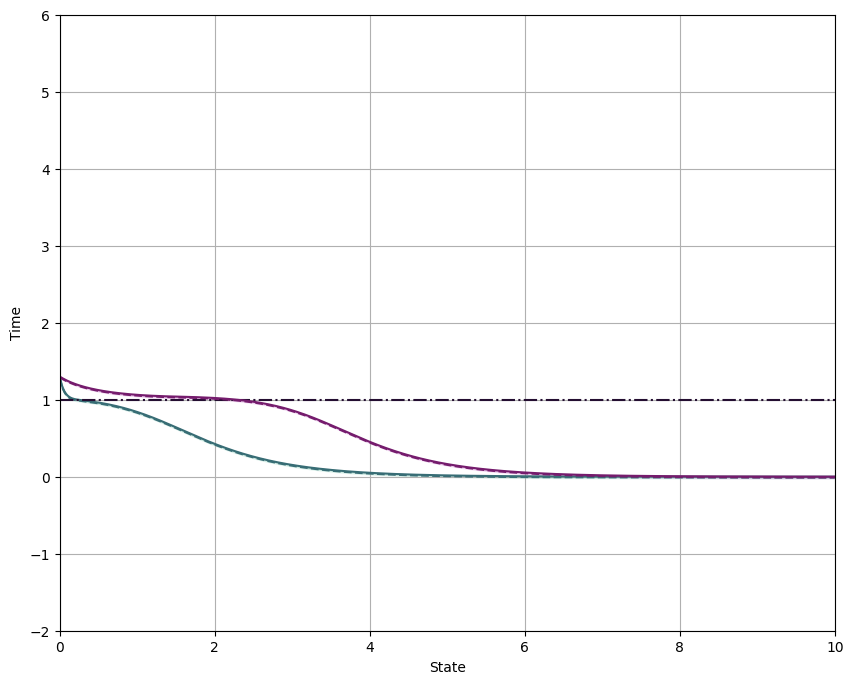

In [270]:
import matplotlib.patches as patches

rgb_colors = np.array(pypalettes.load_cmap("Alexandrite").rgb)/255.0
rgb_colors[2] = rgb_colors[2] * 0.8
black = list(rgb_colors[0])
pink = list(rgb_colors[1])
dark_teal = list(rgb_colors[2])
light_teal = list(rgb_colors[3])
purple = list(rgb_colors[4])
orange = list(rgb_colors[5])
light_purple = list(rgb_colors[6])
teal = list(rgb_colors[7])

# state_history = jnp.stack(state_history)

t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)



plt.figure(figsize=(10, 8))
plt.plot(t_samples, state_history_hjnnv, label="True State Trajectory", c=dark_teal)
plt.plot(t_samples, state_hat_history_hjnnv, label="Estimated State Trajectory", c=dark_teal, linestyle='--')
plt.plot(jnp.array([0, 10]), jnp.array([1, 1]), label="Safe Boundary", c=black, linestyle='-.', alpha=1.0)

highs = jnp.array([bounds.hi for bounds in state_bounds_history_hjnnv])
lows = jnp.array([bounds.lo for bounds in state_bounds_history_hjnnv])
plt.fill_between(t_samples, lows[:, 0], highs[:, 0], color=teal, alpha=0.2, label="State Bounds")

plt.plot(t_samples, state_history_cbf, label="True State Trajectory", c=purple)
plt.plot(t_samples, state_hat_history_cbf, label="Estimated State Trajectory", c=purple, linestyle='--')

highs = jnp.array([bounds.hi for bounds in state_bounds_history_cbf])
lows = jnp.array([bounds.lo for bounds in state_bounds_history_cbf])
plt.fill_between(t_samples, lows[:, 0], highs[:, 0], color=pink, alpha=0.2, label="State Bounds")


# plt.gca().add_patch(patches.Rectangle((0, 0), 10, 10, linestyle='-.', linewidth=1.5, edgecolor=light_purple, facecolor='none', label="Safe Boundary"))

# for i in range(len(state_bounds_history)):
#     bounds = state_bounds_history[i]
#     lo = bounds.lo
#     hi = bounds.hi
#     if i == len(state_bounds_history) - 1:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1,
#             edgecolor=teal + [0.75],
#             facecolor=teal + [0.25],
#             label="State Bounds",
#             zorder=0
#         )
#     else:
#         rect = plt.Rectangle(
#             (lo[0], lo[1]),
#             hi[0] - lo[0],
#             hi[1] - lo[1],
#             linewidth=1.1,
#             edgecolor=teal + [0.4],
#             facecolor=teal + [0.02],
#             zorder=0
#         )
#     plt.gca().add_patch(rect)
plt.xlabel("State")
plt.ylabel("Time")
# plt.title("Trajectory: {} Filtering with Noisy Estimates".format(filter_type))
# plt.legend(loc="lower right", bbox_to_anchor=(1.18, 0.0), framealpha=1.0)
plt.xlim(0, 10)
plt.ylim(-2, 6)
plt.grid(True)
plt.show()

In [ ]:
def simulate_filter(filter_type, epsilon, num_steps=1000):
    dt = 0.01
    max_input = 8.0
    max_disturbance = 1e-12
    obs_disturbance = 1e-12
    seed = 0
    dynamics = CBF_Comparison(
        dt=dt,
        max_input=max_input,
        max_disturbance=max_disturbance,
        obs_disturbance=obs_disturbance,
        model_name=None
    )
    if filter_type in ["hjnnv_bestu", "hjnnv_maxval", "hj"]:
        grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
                    hj.sets.Box(
                        np.array([-6.]),
                        np.array([6.])),
                    (50,),
                )
        values = -jnp.power(grid.states[..., 0], 2) + 1

        solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                        hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
        cmap = 'viridis'

        def estimation_function(observation):
            return observation

        hjnnv_filter = hjnnvUncertaintyAwareFilter(
            dynamics=dynamics,
            pred_model=estimation_function,
            grid=grid,
            initial_values=values,
            num_controls=50,
            num_disturbances=3,
            time_horizon=10.0
        )

    eps_multiplier = 1.0

    state_history = []
    state_hat_history = []
    state_bounds_history = []

    key = jax.random.PRNGKey(seed)
    num_steps = 1000
    dynamics.set_random_seed(seed)

    state = jnp.array([1.3])
    state_hat = state + jax.random.uniform(key, minval=-epsilon, maxval=epsilon, shape=state.shape)
    # state_hat = state + epsilon * eps_multiplier
    u = cbf_controller(state)
    zero_counter = 0

    for step in range(num_steps):
        key, subkey = jax.random.split(key)
        t = step * dynamics.dt
        # Simulate the system dynamics
        obs = dynamics.get_observation(state, time=step)
        u_nominal = cbf_controller(state)
        state_hat = state + jax.random.uniform(subkey, minval=-epsilon, maxval=epsilon, shape=state.shape)
        # state_hat = state + epsilon * eps_multiplier
        # if step > 500 and step < 600:
        #     state_hat = state - epsilon * eps_multiplier
        
        time_start = time.time()
        if filter_type == "hjnnv_maxval" or filter_type == "hjnnv_bestu":
            state_bounds = hj.sets.Box(state_hat - epsilon, state_hat + epsilon)

            if filter_type == "hjnnv_maxval":
                v_star, u_star, worst_val, val_filter, min_vals, distances = hjnnv_filter.ua_filter_max_val(
                    u_nominal,
                    state_bounds,
                    num_states=3,
                    eps=1e-6
                )
            elif filter_type == "hjnnv_bestu":
                v_star, u_star, worst_val, val_filter, min_vals, distances, _, _, = hjnnv_filter.ua_filter_best_u(
                    u_nominal,
                    state_bounds,
                    num_states=10,
                    delta=0.01,
                )
        elif filter_type == "hj":

            lo = state - 1e-8
            hi = state + 1e-8
            state_bounds = hj.sets.Box(
                lo,
                hi
            )
            time_start = time.time()
            v_star, u_star, worst_val, val_filter, min_vals, distances = hjnnv_filter.ua_filter_max_val(
                u_nominal,
                state_bounds,
                num_states=2
            )
        elif filter_type == "r-cbf":
            state_bounds = hj.sets.Box(state_hat - epsilon, state_hat + epsilon)

            state_hat_ = state_hat[0]
            Lfh = -2 * np.power(state_hat_, 2) * (state_hat_ - 1.05) * (state_hat_ + 1.05)
            Lgh = -2 * state_hat_ * (1 - np.power(state_hat_, 2))
            alphah = 1 - np.power(state_hat_, 2)
            rho = 0.2 * Lgh * (Lgh + 1)

            P = matrix([[2.0]])
            q = matrix([0.0])
            G = matrix([[-float(Lgh)]])
            h = matrix([float(Lfh + alphah - rho)])

            sol = solvers.qp(P, q, G, h)
            u_star = np.array([sol['x'][0]])
            v_star = 0.0
            val_filter = -1.0  # negative value means filtering applied

        elif filter_type == "mr-cbf":
            state_bounds = hj.sets.Box(state_hat - epsilon, state_hat + epsilon)

            state_hat_ = state_hat[0]

            if state_hat_ < 100:
                u_opt = cp.Variable((1,))
                objective = cp.Minimize(cp.quad_form(u_opt, 0.5 * np.eye(1)))
                Lfh = -2 * np.power(state_hat_, 2) * (state_hat_ - 1.05) * (state_hat_ + 1.05)
                Lgh = -2 * state_hat_ * (1 - np.power(state_hat_, 2))
                alphah = 1 - np.power(state_hat_, 2)
                
                # Lipschitz constants
                L_Lfh = 3.59
                L_Lgh = 4
                L_alphaoh = 2

                constraints = [
                    Lfh + Lgh * u_opt[0] + alphah - epsilon * (L_Lfh + L_alphaoh) - epsilon * L_Lgh * cp.abs(u_opt[0]) >= 0
                ]
                prob = cp.Problem(objective, constraints)
                try:
                    prob.solve(warm_start=True, verbose=False)
                except:
                    pass
                # prob.solve(warm_start=True, verbose=False)
                u_star = u_opt.value
                if u_star is None:
                    u_star = u_nominal
            else:
                u_star = u_nominal

            # P = matrix([[2.0]])
            # q = matrix([0.0])
            # G = matrix([[float(epsilon * L_Lgh - Lgh)]])
            # h = matrix([float(Lfh + alphah - epsilon * (L_Lfh + L_alphaoh))])

            # sol = solvers.qp(P, q, G, h)
            
            # u_star = np.array([sol['x'][0]])
            v_star = 0.0
            val_filter = -1.0  # negative value means filtering applied

        elif filter_type == "none":
            u = u_nominal
            v_star = 0.0
            val_filter = 1.0  # positive value means no hjnnv filtering
            lo = state - 1e-8
            hi = state + 1e-8
            state_bounds = hj.sets.Box(
                lo,
                hi
            )
        # if np.linalg.norm(state-1.0) < 1e-2:
        #     print(f"Step {step}: State near equilibrium, applying nominal control.")
        #     zero_counter += 1
        #     u = u_nominal
        # elif zero_counter < 100 and zero_counter > 0:
        #     print(f"Step {step}: In zero counter phase ({zero_counter}/100), applying nominal control.")
        #     zero_counter += 1
        #     u = u_nominal
        #     if zero_counter == 100:
        #         zero_counter = 0
        # else:
        if val_filter < 0.0:
            # print(f"Step {step}: Using filtered control u_star={u_star}, state={state}, v_star={v_star}, val_filter={val_filter}")
            u = u_star
        else:
            u = u_nominal
        
        time_end = time.time()
        # print(f"Step {step}: Filter execution time: {time_end - time_start:.5f} seconds")

        state_history.append(state)
        state_hat_history.append(state_hat)
        state_bounds_history.append(state_bounds)

        state = dynamics.step(state, u, dynamics.get_random_disturbance(), time=step)

    # print(f"Filter type: {epsilon}, u_min: {u_min}, u_max: {u_max}")
    
    return state_history, state_hat_history, state_bounds_history

        

In [483]:


mrcbf_history_dict = {}
rcbf_history_dict = {}
hjnnv_history_dict = {}
eps_list = [0.01, 0.05, 0.1, 0.2, 0.5, 0.8]
# eps_list = [0.01, 0.05]

for eps in eps_list:
    # print(f"Simulating MR-CBF filter with epsilon={eps}")
    # history = simulate_filter("mr-cbf", epsilon=eps)
    # state_history_mrcbf = history[0]
    # state_hat_history_mrcbf = history[1]
    # state_bounds_history_mrcbf = histo|ry[2]
    # mrcbf_history_dict[eps] = (state_history_mrcbf, state_hat_history_mrcbf, state_bounds_history_mrcbf)

    print(f"Simulating R-CBF filter with epsilon={eps}")
    history = simulate_filter("r-cbf", epsilon=eps)
    state_history_cbf = history[0]
    state_hat_history_cbf = history[1]
    state_bounds_history_cbf = history[2]
    rcbf_history_dict[eps] = (state_history_cbf, state_hat_history_cbf, state_bounds_history_cbf)

    print(f"Simulating HJNNV filter with epsilon={eps}")
    history = simulate_filter("hjnnv_bestu", epsilon=eps)
    state_history_hjnnv = history[0]
    state_hat_history_hjnnv = history[1]
    state_bounds_history_hjnnv = history[2]
    hjnnv_history_dict[eps] = (state_history_hjnnv, state_hat_history_hjnnv, state_bounds_history_hjnnv)

Simulating R-CBF filter with epsilon=0.01
Simulating HJNNV filter with epsilon=0.01


100%|##########| 10.0000/10.0 [00:05<00:00,  1.71sim_s/s]


Simulating R-CBF filter with epsilon=0.05
Simulating HJNNV filter with epsilon=0.05


100%|##########| 10.0000/10.0 [00:05<00:00,  1.74sim_s/s]


Simulating R-CBF filter with epsilon=0.1
Simulating HJNNV filter with epsilon=0.1


100%|##########| 10.0000/10.0 [00:05<00:00,  1.69sim_s/s]


Simulating R-CBF filter with epsilon=0.2
Simulating HJNNV filter with epsilon=0.2


100%|##########| 10.0000/10.0 [00:05<00:00,  1.69sim_s/s]


Simulating R-CBF filter with epsilon=0.5
Simulating HJNNV filter with epsilon=0.5


100%|##########| 10.0000/10.0 [00:05<00:00,  1.69sim_s/s]


Simulating R-CBF filter with epsilon=0.8
Simulating HJNNV filter with epsilon=0.8


100%|##########| 10.0000/10.0 [00:05<00:00,  1.67sim_s/s]


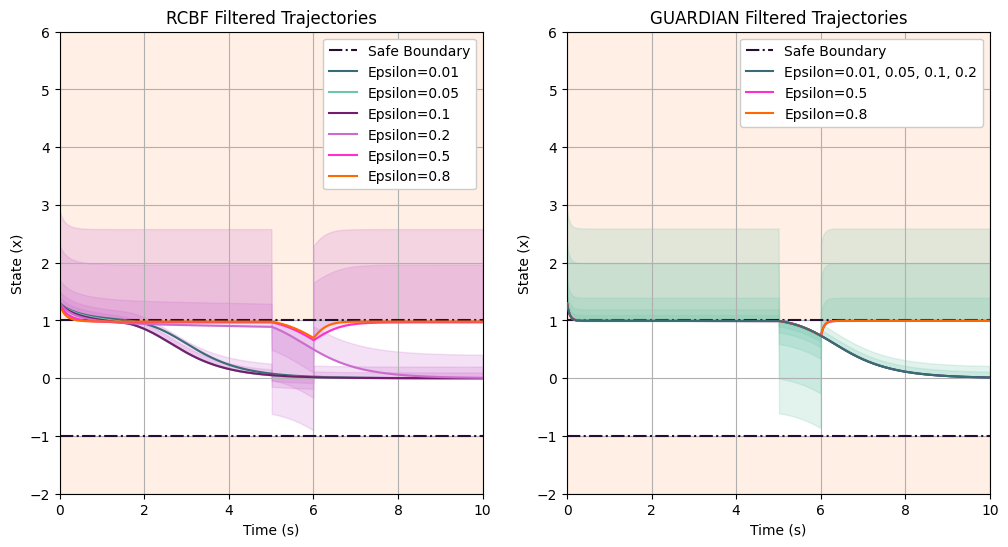

In [484]:
rgb_colors = np.array(pypalettes.load_cmap("Alexandrite").rgb)/255.0
rgb_colors[2] = rgb_colors[2] * 0.8
black = list(rgb_colors[0])
pink = list(rgb_colors[1])
dark_teal = list(rgb_colors[2])
light_teal = list(rgb_colors[3])
purple = list(rgb_colors[4])
orange = list(rgb_colors[5])
yellow = [240/255.0, 225/255.0, 0/255.0]  # yellow
dark_orange = [255/255.0, 103/255.0, 0/255.0]
# gray = [70/255.0, 45/255.0, 255/255.0]  # red
# gray = dark_orange
light_purple = list(rgb_colors[6])
teal = list(rgb_colors[7])
hot_pink = [1.0, 46/255.0, 204/255.0]  # hot pink

color_dict = {
    0.01: dark_teal,
    0.05: teal,
    0.1: purple,
    0.2: pink,
    0.5: hot_pink,
    0.8: dark_orange,
    1.1: black
}
safe_region_color = dark_orange
rect_alpha = 0.1

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for ax in axs:
    rect_l = patches.Rectangle(
        (0, -2),
        10,
        1,
        linestyle='-',
        linewidth=1.0,
        edgecolor=safe_region_color,
        facecolor=safe_region_color,
        alpha=rect_alpha,
        zorder=0
    )
    rect_u = patches.Rectangle(
        (0, 1),
        10,
        9,
        linestyle='-',
        linewidth=1.0,
        edgecolor=safe_region_color,
        facecolor=safe_region_color,
        alpha=rect_alpha,
        zorder=0
    )
    ax.add_patch(rect_l)
    ax.add_patch(rect_u)
    ax.plot(jnp.array([0, 10]), jnp.array([1, 1]), label="Safe Boundary", c=black, linestyle='-.', alpha=1.0)
    ax.plot(jnp.array([0, 10]), jnp.array([-1, -1]), c=black, linestyle='-.', alpha=1.0)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("State (x)")
    ax.set_xlim(0, 10)
    ax.set_ylim(-2.0, 6.0)
    ax.grid(True)

for eps in eps_list:
    state_history_rcbf, state_hat_history_rcbf, state_bounds_history_rcbf = rcbf_history_dict[eps]
    # state_history_mrcbf, state_hat_history_mrcbf, state_bounds_history_mrcbf = mrcbf_history_dict[eps]
    state_history_hjnnv, state_hat_history_hjnnv, state_bounds_history_hjnnv = hjnnv_history_dict[eps]

    t_samples = np.linspace(0, num_steps * dynamics.dt, num_steps)

    if eps==0.01:
        label_eps = f"Epsilon=0.01, 0.05, 0.1, 0.2"
        axs[1].plot(t_samples, state_history_hjnnv, c=color_dict[eps], label=label_eps, zorder=10)
    elif eps in [0.05, 0.1, 0.2]:
        axs[1].plot(t_samples, state_history_hjnnv, c=color_dict[eps])
    else:
        label_eps = f"Epsilon={eps}"
        axs[1].plot(t_samples, state_history_hjnnv, c=color_dict[eps], label=label_eps)
        
    
    # plt.plot(t_samples, state_hat_history_hjnnv, label="Estimated State Trajectory", c=dark_teal, linestyle='--')
    

    highs = jnp.array([bounds.hi for bounds in state_bounds_history_hjnnv])
    lows = jnp.array([bounds.lo for bounds in state_bounds_history_hjnnv])
    axs[1].fill_between(t_samples, lows[:, 0], highs[:, 0], color=teal, alpha=0.2)

    axs[0].plot(t_samples, state_history_rcbf, c=color_dict[eps], label=f"Epsilon={eps}")
    # axs[0].plot(t_samples, state_history_mrcbf, c=color_dict[eps], linestyle='--', label=f"MR-CBF Epsilon={eps}")
    # axs[0].plot(t_samples, state_hat_history_rcbf, label="Estimated State Trajectory", c=purple, linestyle='--')

    highs = jnp.array([bounds.hi for bounds in state_bounds_history_rcbf])
    lows = jnp.array([bounds.lo for bounds in state_bounds_history_rcbf])
    axs[0].fill_between(t_samples, lows[:, 0], highs[:, 0], color=pink, alpha=0.2)

axs[0].set_title("RCBF Filtered Trajectories")
axs[1].set_title("GUARDIAN Filtered Trajectories")
axs[0].legend(loc="upper right", framealpha=1.0)
axs[1].legend(loc="upper right", framealpha=1.0)

